In [1]:
""" 
Code hiding:
http://blog.nextgenetics.net/?e=102
"""
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
%matplotlib nbagg
import ipywidgets as ipw
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display
from pathlib import Path

import functions as fn

pulses = None
files = None
f = None
std_window_size = 1000
std_step = 300
pulse_number_array = None
min_sd = None
max_sd = None

In [3]:
def check_pulse_window():
    r = sorted([abs(ctrl_min_pulse_window.value), abs(ctrl_max_pulse_window.value)])
    ctrl_min_pulse_window.value, ctrl_max_pulse_window.value = r
    
    if ctrl_min_pulse_window.value < 1: 
        ctrl_min_pulse_window.value = 1
        
    if ctrl_max_pulse_window.value > ctrl_n_bins.value:
        ctrl_max_pulse_window.value = ctrl_n_bins.value

def check_pulses_range():
    r = sorted([abs(ctrl_min_pulse.value), abs(ctrl_max_pulse.value)])
    ctrl_min_pulse.value, ctrl_max_pulse.value = r
    
    if ctrl_min_pulse.value < 1:
        ctrl_min_pulse.value = 1
        
    if ctrl_max_pulse.value > ctrl_n_pulses.value:       
        ctrl_max_pulse.value = ctrl_n_pulses.value

def enable_controls():
    ctrl_min_pulse.disabled = False
    ctrl_max_pulse.disabled = False
    btn_plot_mean.disabled = False
    ctrl_min_pulse_window.disabled = False
    ctrl_max_pulse_window.disabled = False
    btn_set_pulse_window.disabled = False
    btn_run_analysis.disabled = False
    
def on_path_change(value):
    global files
    global f
    path = Path(value['new'])
    files = sorted(path.glob('*.h5'))
    f = sorted([a.name for a in files])
    if len(f) > 0:
        ctrl_file.options = f
        ctrl_file.disabled = False
        btn_select.disabled = False
    else:
        ctrl_file.options = []
        ctrl_file.disabled = True
        btn_select.disabled = True

def on_std_step_change(value):
    global std_step
    if value['new'] < 1:
        ctrl_std_step.value = 1
    std_step = ctrl_std_step.value
    
        
def on_std_window_size_change(value):
    global std_window_size
    if value['new'] < 5:
        ctrl_std_window_size.value = 5
    std_window_size = ctrl_std_window_size.value

def plot_mean_profile(b):
    check_pulses_range()
    plt.clf()
    plt.plot(fn.get_mean_profile(pulses[ctrl_min_pulse.value - 1:ctrl_max_pulse.value]), label='Mean profile')
    plt.axvline(ctrl_min_pulse_window.value)
    plt.axvline(ctrl_max_pulse_window.value)
    plt.xlabel('Phase bin')
    plt.ylabel('Flux [mJy]')
    plt.legend()
    plt.show()
    
def plot_sd(min_sd, max_sd):
    """ Plots minimum and maximum standard deviation series"""
    
    plt.clf()
    top = plt.subplot2grid((2, 1), (0, 0))
    top.plot(pulse_number_array, min_sd, label='Min std')
    plt.xlabel('Pulse number')
    plt.ylabel('Flux [mJy]')
    plt.legend()

    bottom = plt.subplot2grid((2, 1), (1, 0), sharex=top)
    bottom.plot(pulse_number_array, max_sd, label='Max std')
    plt.xlabel('Pulse number')
    plt.ylabel('Flux [mJy]')
    plt.legend()

    plt.show()
        
def read_data(b):
    global pulses
    to_read = files[f.index(ctrl_file.value)]
    pulses = fn.read_data(to_read)
    ctrl_n_pulses.value = pulses.shape[0]
    ctrl_n_bins.value = pulses.shape[1]
    
    enable_controls()
    
    ctrl_max_pulse.value = ctrl_n_pulses.value
    ctrl_min_pulse.value = 1
    ctrl_min_pulse_window.value = 1
    ctrl_max_pulse_window.value = ctrl_n_bins.value
  
def run_analysis(b):
    global min_sd
    global max_sd
    global pulse_number_array 
    
    pulse_number_array = np.array(range(ctrl_min_pulse.value, ctrl_max_pulse.value + 1))
    sd = fn.get_sd_from_pulses(pulses[ctrl_min_pulse.value - 1:ctrl_max_pulse.value], std_window_size, std_step)
    min_sd = sd[:, 0, 0]
    max_sd = sd[:, 1, 0]
    plot_sd(min_sd, max_sd)
    

def set_pulse_window(b):
    check_pulse_window()
    
ctrl_path = ipw.Text(
    placeholder='Path to data directory',
    description='Path:',
    disabled=False
)

ctrl_file = ipw.Dropdown(
    options=[],
    description='Select file:',
    disabled=True
)

btn_select = ipw.Button(
    description='Accept',
    disabled=True

)

ctrl_n_pulses = ipw.IntText(
    description='Number of pulses',
    disabled=True,
    value = 0
)

ctrl_n_bins = ipw.IntText(
    description='Binning',
    disabled=True,
    value=0
)

ctrl_min_pulse = ipw.IntText(
    description='From:',
    disabled=True,
    value=1
)

ctrl_max_pulse = ipw.IntText(
    description='To:',
    disabled=True,
    value=1
)

btn_plot_mean = ipw.Button(
    description='Plot mean profile',
    disabled=True
)

ctrl_min_pulse_window = ipw.IntText(
    description='From:',
    disabled=True,
    value=1
)

ctrl_max_pulse_window = ipw.IntText(
    description='To:',
    disabled=True,
    value=1
)

btn_set_pulse_window = ipw.Button(
    description='Set pulse window',
    disabled=True
)

btn_run_analysis = ipw.Button(
    description='Run analysis',
    disabled=True,
    button_style='primary'
)

ctrl_std_window_size = ipw.IntText(
    description='Std window size',
    value=std_window_size
)

ctrl_std_step = ipw.IntText(
    description='Std step',
    value=std_step
)

<IPython.core.display.Javascript object>


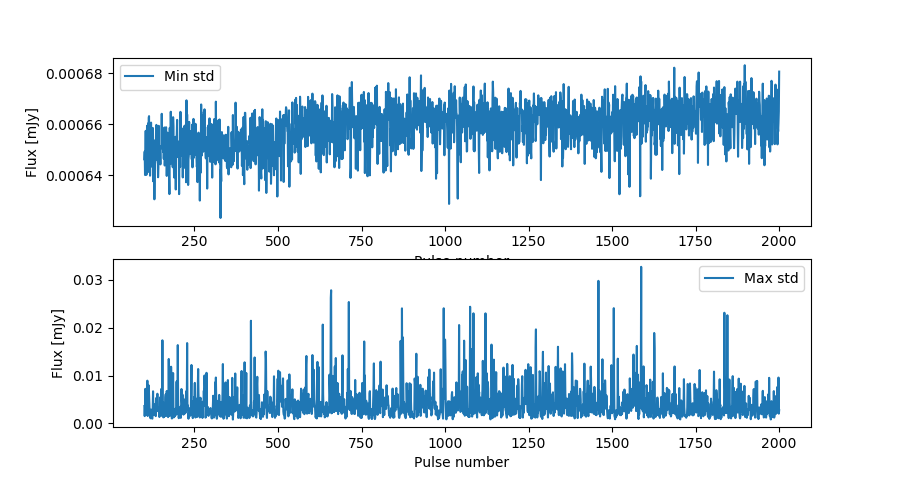

In [4]:
# events handling
ctrl_path.observe(on_path_change, names='value')
btn_select.on_click(read_data)
btn_plot_mean.on_click(plot_mean_profile)
btn_set_pulse_window.on_click(set_pulse_window)
btn_run_analysis.on_click(run_analysis)
ctrl_std_window_size.observe(on_std_window_size_change, names='value')
ctrl_std_step.observe(on_std_step_change, names='value')

#layout
l1 = ipw.HBox([ctrl_path, ctrl_file, btn_select])
l2 = ipw.HBox([ctrl_n_pulses, ctrl_n_bins])
l3 = ipw.HBox([ctrl_min_pulse, ctrl_max_pulse, btn_plot_mean])
l4 = ipw.HBox([ctrl_min_pulse_window, ctrl_max_pulse_window, btn_set_pulse_window])
l5 = ipw.HBox([ctrl_std_window_size, ctrl_std_step, btn_run_analysis])
ipw.VBox([l1, l2, l3, l4, l5])